In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn import linear_model as lm

# Part I

## Data Generation

Generate the 20 centers, 10 for each group

In [2]:
np.random.seed(100)

csize = 10      
p = 2      
s = 1;      # sd for generating the centers within each class                    
m1 = np.random.normal(size = (csize, p)) * s \
     + np.concatenate([np.array([[1, 0]] * csize)])
m0 = np.random.normal(size = (csize, p)) * s \
     + np.concatenate([np.array([[0, 1]] * csize)])

Generate training data

In [16]:
np.random.seed(100)

n_train = 100

# Randomly allocate the n samples for class 1  to the 10 clusters
id1 = np.random.randint(csize, size = n_train)
id0 = np.random.randint(csize, size = n_train)

# sd for generating data  
s = np.sqrt(float(1)/5) 

train_x = np.random.normal(size = (2 * n_train, p)) * s \
            + np.concatenate([m1[id1,:], m0[id0,:]])
train_y = np.concatenate(([1]*n_train, [0]*n_train))

Generate test data

In [17]:
np.random.seed(100)

n_test = 5000

# Randomly allocate the n samples for class 1  to the 10 clusters
id1 = np.random.randint(csize, size = n_test)
id0 = np.random.randint(csize, size = n_test)

# sd for generating data  
s = np.sqrt(float(1)/5) 

test_x = np.random.normal(size = (2 * n_test, p)) * s \
            + np.concatenate([m1[id1,:], m0[id0,:]])
test_y = np.concatenate(([1]*n_test, [0]*n_test))

## Visualization

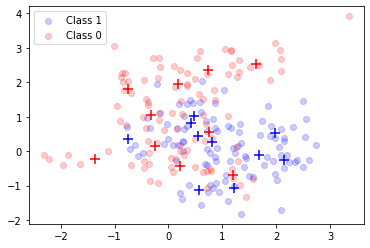

In [18]:
plt.scatter(train_x[:n_train, 0], train_x[:n_train, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(train_x[n_train:, 0], train_x[n_train:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(m1[:,0], m1[:,1], marker = '+', s = 100, c = "blue")
plt.scatter(m0[:,0], m0[:,1], marker = '+', s = 100, c = "red")

plt.legend()
plt.show()

# Part II: kNN

Define myknn:
If distance ties, it will return based the original sample order, but this won't appear as the locations are random;
If votes ties, it will always return 0

In [30]:
class myknn:
    def __init__(self, train_x, train_y, test_x, k):
#train_x.shape = (n, p)
#train_y.shape = (n, 1)
#test_x.shape = (m, p)
        self.train_x = train_x
        n = train_y.shape[0]
        self.train_y = train_y.reshape(n,1)
        self.test_x = test_x
        self.k = k
    
    def fit(self):
        (n,p) = train_x.shape
        (m,p) = test_x.shape
        u = np.sum(self.train_x**2,axis=1)
        v = np.sum(self.test_x**2,axis=1)
        A = np.tile(u,(m,1)).T
        B = np.tile(v,(n,1))
        C= np.dot(self.train_x,self.test_x.T)
        # self.distance matrix shape (n,m)
        self.distance = A + B -2*C 
        Y_label = np.tile(self.train_y,(1,m))
        # sort the distance
        sorted_indices = np.argsort(self.distance,axis = 0)
        new_Y_label = np.take_along_axis(Y_label,sorted_indices,axis = 0)
        most_common_values = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=new_Y_label[:k,:])
        
        return most_common_values    

Compare with the sklearn buildin knn function in the case k = 1/3/5

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [32]:
k = 1
knn = myknn(train_x,train_y,test_x,k)
prediction = knn.fit()
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(train_x, train_y)
prediction_sklearn = neigh.predict(test_x)
cm = confusion_matrix(test_y, prediction)
cm_sklearn = confusion_matrix(test_y, prediction_sklearn)
print(cm)
print(cm_sklearn)

[[3506 1494]
 [1511 3489]]
[[3506 1494]
 [1511 3489]]


In [33]:
k = 3
knn = myknn(train_x,train_y,test_x,k)
prediction = knn.fit()
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(train_x, train_y)
prediction_sklearn = neigh.predict(test_x)
cm = confusion_matrix(test_y, prediction)
cm_sklearn = confusion_matrix(test_y, prediction_sklearn)
print(cm)
print(cm_sklearn)

[[3585 1415]
 [1269 3731]]
[[3585 1415]
 [1269 3731]]


In [34]:
k = 5
knn = myknn(train_x,train_y,test_x,k)
prediction = knn.fit()
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(train_x, train_y)
prediction_sklearn = neigh.predict(test_x)
cm = confusion_matrix(test_y, prediction)
cm_sklearn = confusion_matrix(test_y, prediction_sklearn)
print(cm)
print(cm_sklearn)

[[3521 1479]
 [1105 3895]]
[[3521 1479]
 [1105 3895]]


# Part III: cvkNN

In [37]:
myk = range(1,181)
num_folds = 10
n = len(train_y)
m = len(myk)
cverr = np.zeros(m)

indices = np.arange(n)
np.random.shuffle(indices)
index_sets = np.array_split(indices, num_folds)

for ifold in range(num_folds):
    train_indices =  np.delete(index_sets, obj=ifold, axis=0).ravel()
    _traindata = train_x[train_indices]
    _Ytrain = train_y[train_indices]
    
    test_indices = index_sets[ifold]
    _testdata = train_x[test_indices]
    _Ytest = train_y[test_indices]
   
    for j in range(m):
        K = myk[j]
        knn_model = KNeighborsClassifier(K)
        knn_model.fit(_traindata, _Ytrain)
        predict_Y = knn_model.predict(_testdata)
        cverr[j] += sum(predict_Y != _Ytest)
    
cverr /= float(n)
cverr

array([0.315, 0.315, 0.23 , 0.225, 0.225, 0.24 , 0.235, 0.225, 0.21 ,
       0.22 , 0.22 , 0.255, 0.235, 0.275, 0.26 , 0.265, 0.25 , 0.27 ,
       0.26 , 0.27 , 0.245, 0.25 , 0.23 , 0.245, 0.215, 0.245, 0.205,
       0.235, 0.215, 0.23 , 0.245, 0.245, 0.23 , 0.225, 0.24 , 0.23 ,
       0.24 , 0.245, 0.245, 0.265, 0.245, 0.25 , 0.265, 0.265, 0.255,
       0.255, 0.255, 0.26 , 0.26 , 0.255, 0.255, 0.255, 0.255, 0.255,
       0.255, 0.255, 0.26 , 0.26 , 0.265, 0.26 , 0.27 , 0.27 , 0.27 ,
       0.275, 0.285, 0.27 , 0.275, 0.275, 0.275, 0.275, 0.28 , 0.27 ,
       0.27 , 0.26 , 0.28 , 0.27 , 0.275, 0.275, 0.285, 0.285, 0.285,
       0.29 , 0.28 , 0.28 , 0.275, 0.27 , 0.28 , 0.275, 0.28 , 0.28 ,
       0.285, 0.29 , 0.285, 0.285, 0.285, 0.29 , 0.285, 0.285, 0.285,
       0.29 , 0.29 , 0.295, 0.29 , 0.295, 0.29 , 0.295, 0.295, 0.305,
       0.29 , 0.3  , 0.29 , 0.305, 0.295, 0.305, 0.31 , 0.315, 0.315,
       0.32 , 0.31 , 0.315, 0.315, 0.315, 0.315, 0.315, 0.31 , 0.315,
       0.315, 0.32 ,

In [52]:
k_selected = np.argmin(cverr)+1
neigh = KNeighborsClassifier(n_neighbors=k_selected)
neigh.fit(train_x, train_y)
prediction_sklearn = neigh.predict(test_x)
cm_selected = confusion_matrix(test_y, prediction_sklearn)
print(cm_selected)

[[3473 1527]
 [ 955 4045]]
